# Flower Classification Model

In [262]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import math
import re

from tensorflow import keras
from tensorflow.keras import layers

tfds.disable_progress_bar()

In [263]:
np.random.seed(42)
tf.random.set_seed(42)

In [264]:
IMAGE_SIZE = [224, 224]
AUTO = tf.data.experimental.AUTOTUNE
BUFFER_SIZE = 1000
BATCH_SIZE = 16

Scan file names for data loading

In [265]:
TRAIN_FILENAMES = tf.io.gfile.glob('./train/*.tfrec')
print('Train set TFRecord Files:', len(TRAIN_FILENAMES))

VAL_FILENAMES = tf.io.gfile.glob('./val/*.tfrec')
print('Val set TFRecord Files:', len(VAL_FILENAMES))

TEST_FILENAMES = tf.io.gfile.glob('./test/*.tfrec')
print('Test set TFRecord Files:', len(TEST_FILENAMES))

Train set TFRecord Files: 2
Val set TFRecord Files: 2
Test set TFRecord Files: 1


104 Flower Classes

In [266]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose'] 

**Utility functions for data preprocessing and preparation**

In [267]:
def decode_image(image):

  image = tf.image.decode_jpeg(image, channels=3)
  
  image = tf.cast(image, tf.float32) / 255.0  # normalize images to [0,1] range
  image = tf.reshape(image, [*IMAGE_SIZE, 3])  

  return image

In [268]:
# for train, validation data

def read_labeled_tfrecord(example):

  labeled_tfrecord_format = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'class': tf.io.FixedLenFeature([], tf.int64),
  }

  example = tf.io.parse_single_example(example, labeled_tfrecord_format)

  image = decode_image(example['image'])
  label = tf.cast(example['class'], tf.int32)

  return image, label   # return a dataset of (image, label) pair

In [269]:
# for test data

def read_unlabeled_tfrecord(example):

  unlabeled_tfrecord_format = {
      'image': tf.io.FixedLenFeature([], tf.string),
      'id': tf.io.FixedLenFeature([], tf.string),
  }

  example = tf.io.parse_single_example(example, unlabeled_tfrecord_format)

  image = decode_image(example['image'])
  idnum = example['id']

  return image, idnum  # return a dataset of (image, id) pair

In [270]:
def load_dataset(filenames, labeled = True, ordered = False):
  
  # reading from multiple files at once and ignore data order
  ignore_order_on_read = tf.data.Options()
  
  if not ordered:
    ignore_order_on_read.deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(ignore_order_on_read)
  dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)

  return dataset

In [271]:
# data augmentation to apply slight transformations
# could also use keras.preprocessing.image.ImageDataGenerator 

def data_augment(image, label):

  image = tf.image.random_flip_left_right(image)

  return image, label

In [272]:
def get_train_dataset():

  dataset = load_dataset(TRAIN_FILENAMES, labeled = True)
  dataset = dataset.map(data_augment, num_parallel_calls=AUTO).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

  return dataset

In [273]:
def get_val_dataset(ordered = False):
  
  dataset = load_dataset(VAL_FILENAMES, labeled = True, ordered= ordered)
  dataset = dataset.batch(BATCH_SIZE).cache().prefetch(AUTO)

  return dataset

In [274]:
def get_test_dataset(ordered = False):
  
  dataset = load_dataset(TEST_FILENAMES, labeled = False, ordered = ordered)
  dataset = dataset.batch(BATCH_SIZE).prefetch(AUTO)

  return dataset

Load the datasets

In [275]:
ds_train = get_train_dataset()
ds_val = get_val_dataset()
ds_test = get_test_dataset()

print('Train set:', ds_train)
print('Val set:', ds_val)
print('Test set:', ds_test)

Train set: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Val set: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
Test set: <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>


In [276]:
print("Training data shapes:")

for image, label in ds_train.take(1):
  print(image.numpy().shape, label.numpy().shape)
  
print("Training data label examples:", label.numpy())

Training data shapes:
(16, 224, 224, 3) (16,)
Training data label examples: [89 90 89 ... 72 53 67]


In [277]:
print("Test data shapes:")

for image, idnum in ds_test.take(1):
  print(image.numpy().shape, idnum.numpy().shape)
  
print("Test data IDs:", idnum.numpy().astype('U')) # U=unicode string

Test data shapes:
(16, 224, 224, 3) (16,)
Test data IDs: ['252d840db' 'dfd946ac8' '0c3ae4377' ... 'fe2bfa700' '0435e3c70' '3d2ee2570']


**Utility functions for visualization**

In [278]:
def batch_to_numpy_images_and_labels(data):

  images, labels = data
  numpy_images = images.numpy()
  numpy_labels = labels.numpy()
  
  if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    numpy_labels = [None for _ in enumerate(numpy_images)] 

  return numpy_images, numpy_labels

In [279]:
# function to prepare image title according to classification result

def title_from_label_and_target(label, correct_label):

  if correct_label is None:
    return CLASSES[label], True
  correct = (label == correct_label)

  # if correct, print "class label", otherwise print "class label, [correct label]"
  return "{} [{}]".format(CLASSES[label], CLASSES[correct_label] if not correct else ''), correct

In [280]:
def display_one_flower(image, title, subplot, red=False):

  plt.subplot(*subplot)
  plt.axis('off')
  plt.imshow(image)
  
  if len(title) > 0:
    plt.title(title, color='red' if red else 'black')
    
  return (subplot[0], subplot[1], subplot[2]+1)

In [281]:
def display_batch_of_images(databatch, predictions=None):

  # data
  images, labels = batch_to_numpy_images_and_labels(databatch)
  if labels is None:
    labels = [None for _ in enumerate(images)]
     
  subplot=(4,4,1)
  plt.figure(figsize=(13, 13))
    
  # display
  for i, (image, label) in enumerate(zip(images[:BATCH_SIZE], labels[:BATCH_SIZE])):
    title = '' if label is None else CLASSES[label]
    correct = True
    if predictions is not None:
      title, correct = title_from_label_and_target(predictions[i], label)
    subplot = display_one_flower(image, title, subplot, not correct)
    
  plt.tight_layout()
  plt.show()

In [282]:
def display_training_curves(training, validation, title, subplot):

  plt.subplots(figsize=(10,10))
  plt.tight_layout()
  
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'validation'])
  ax.grid(True)

Create an iterator to display different batches upon running the below cell multiple times

In [283]:
ds_iter = iter(ds_train.unbatch().batch(20))

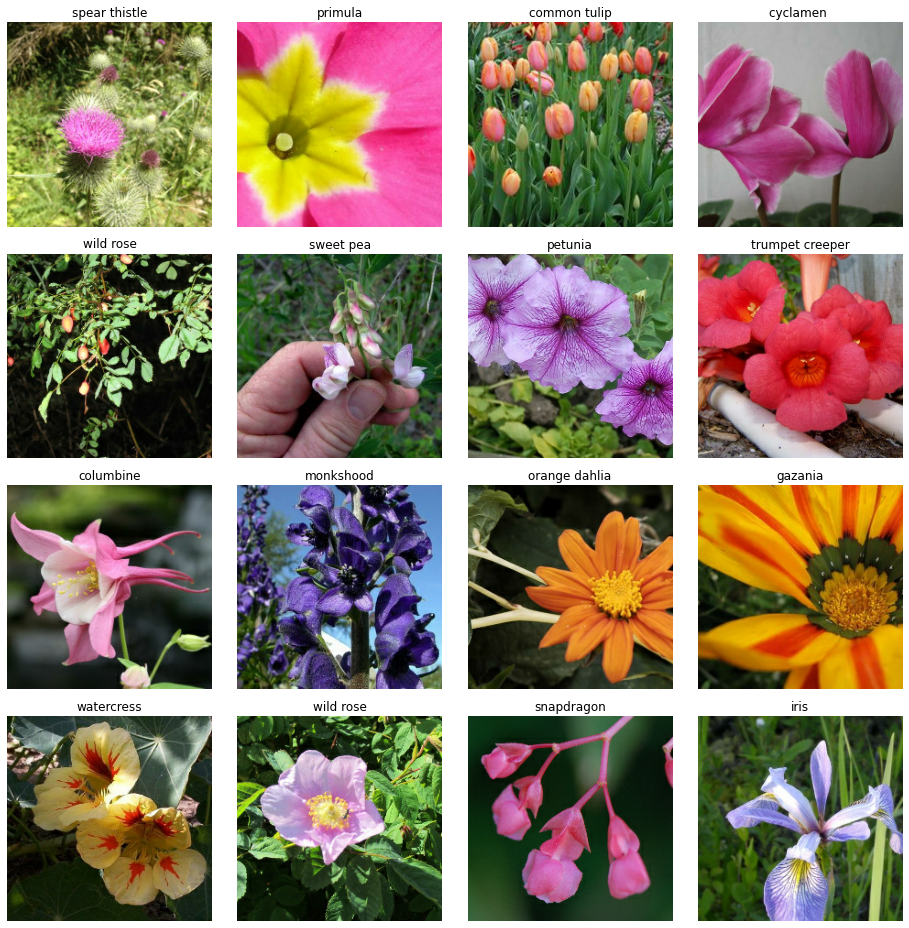

In [284]:
one_batch = next(ds_iter)
display_batch_of_images(one_batch)

**Modeling**

In [285]:
pretrained_model = tf.keras.applications.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = [*IMAGE_SIZE, 3]
)

pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(len(CLASSES), activation='softmax')
])

In [286]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 104)               53352     
                                                                 
Total params: 14,768,040
Trainable params: 53,352
Non-trainable params: 14,714,688
_________________________________________________________________


In [287]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, mode='min')

history = model.fit(ds_train, validation_data=ds_val, epochs = 20, callbacks=[early_stopping_cb])

Epoch 1/20
100/100 [==============================] - 13s 116ms/step - loss: 4.2536 - sparse_categorical_accuracy: 0.0677 - val_loss: 3.9510 - val_sparse_categorical_accuracy: 0.0970
Epoch 2/20
100/100 [==============================] - 9s 79ms/step - loss: 3.8202 - sparse_categorical_accuracy: 0.1378 - val_loss: 3.7337 - val_sparse_categorical_accuracy: 0.1509
Epoch 3/20
100/100 [==============================] - 9s 79ms/step - loss: 3.5833 - sparse_categorical_accuracy: 0.1873 - val_loss: 3.5793 - val_sparse_categorical_accuracy: 0.1810
Epoch 4/20
100/100 [==============================] - 9s 80ms/step - loss: 3.3857 - sparse_categorical_accuracy: 0.2112 - val_loss: 3.4551 - val_sparse_categorical_accuracy: 0.1789
Epoch 5/20
100/100 [==============================] - 9s 80ms/step - loss: 3.2053 - sparse_categorical_accuracy: 0.2506 - val_loss: 3.3278 - val_sparse_categorical_accuracy: 0.2284
Epoch 6/20
100/100 [==============================] - 9s 80ms/step - loss: 3.0528 - sparse_ca

Plot training history

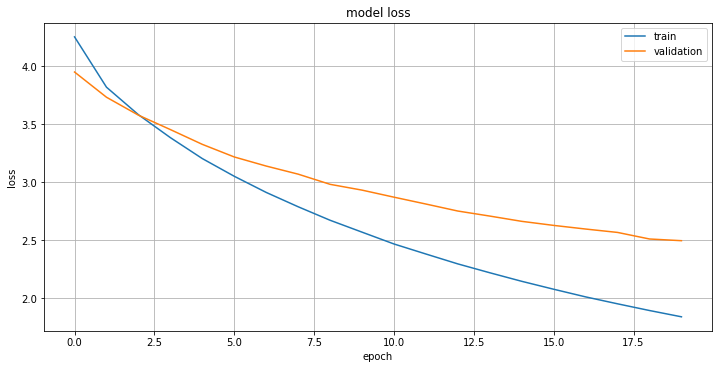

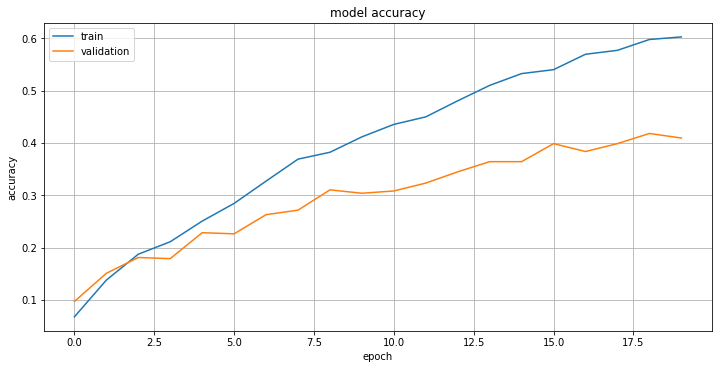

In [288]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['sparse_categorical_accuracy'],
    history.history['val_sparse_categorical_accuracy'],
    'accuracy',
    212,
)

**Metrics Reporting & Results Visualization**

In [289]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

In [290]:
def display_confusion_matrix(cmat):

  plt.figure(figsize=(15,15))
  ax = plt.gca()
  ax.matshow(cmat, cmap='Reds')

  ax.set_xticks(range(len(CLASSES)))
  ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
  plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

  ax.set_yticks(range(len(CLASSES)))
  ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
  plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  plt.show()

In [292]:
# calculate confusion matrix on validation data

cmdataset = get_val_dataset(ordered=True)
images_ds = cmdataset.map(lambda image, label: image)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()

cm_correct_labels = next(iter(labels_ds.batch(464))).numpy()
cm_probabilities = model.predict(images_ds)
cm_predictions = np.argmax(cm_probabilities, axis=-1)

labels = range(len(CLASSES))
cmat = confusion_matrix(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
)

cmat = (cmat.T / cmat.sum(axis=1)).T # normalize

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


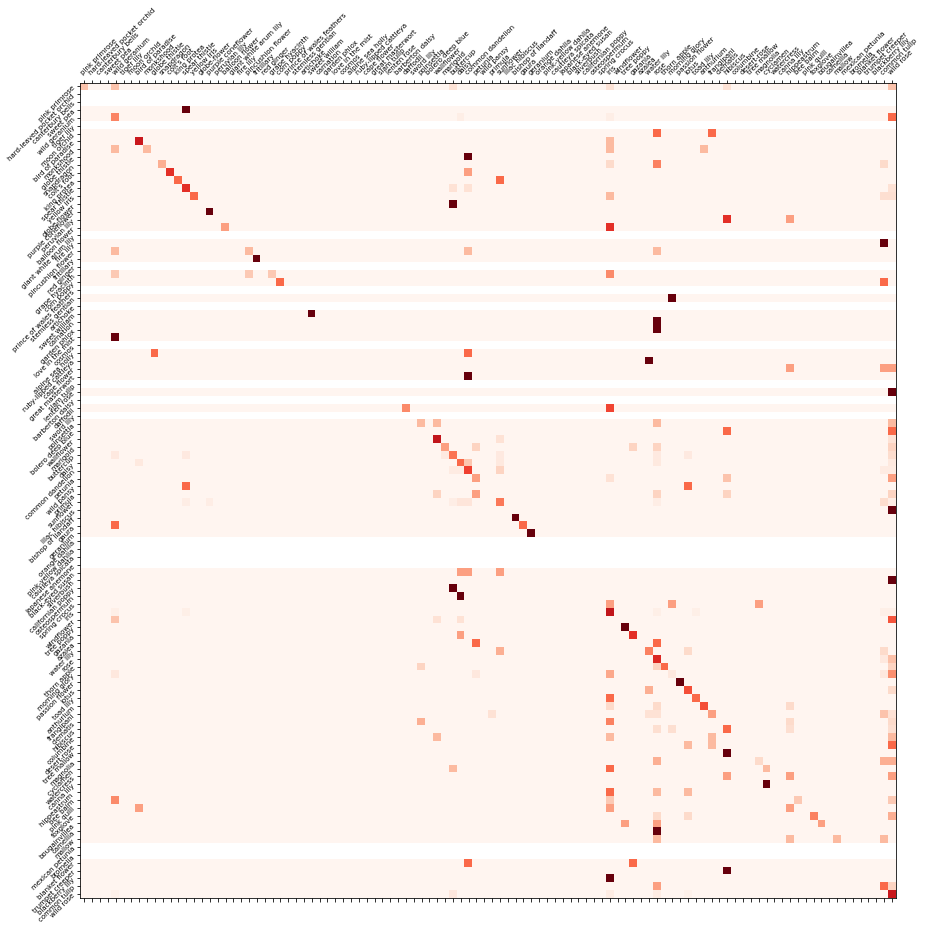

In [293]:
display_confusion_matrix(cmat)

In [294]:
score = f1_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

precision = precision_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

recall = recall_score(
    cm_correct_labels,
    cm_predictions,
    labels=labels,
    average='macro',
)

metrics = {'f1 score': [score], 'precision': [precision], 'recall': [recall]}
metrics_df = pd.DataFrame(data=metrics)
metrics_df

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,f1 score,precision,recall
0,0.251599,0.322556,0.246615


As previously, create an iterator to display different batches upon running the below cell

In [295]:
dataset = get_val_dataset()
dataset = dataset.unbatch().batch(BATCH_SIZE)
batch = iter(dataset)

Run the following cell multiple times to see results of different batches

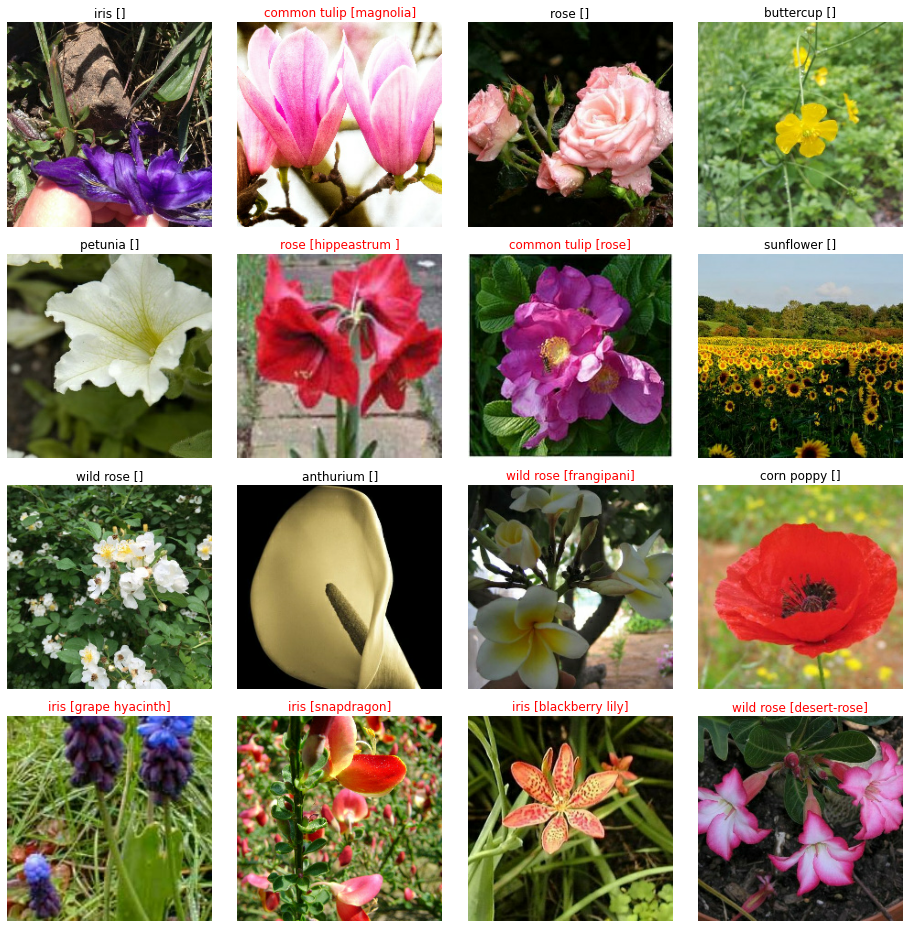

In [297]:
images, labels = next(batch)
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis=-1)
display_batch_of_images((images, labels), predictions)